 # Problema 2 "Diagnostico del Alzheimer" (Grupal)
David Morais  
Eudald Pizarro  
Marc Teixidó  
Joan Montobbio

Con el envejecimiento de la población, la enfermedad de Alzheimer es una de las enfermedades del envejecimiento que ha cobrado mayor relevancia. Es por eso que un diagnóstico a partir de las características del paciente, pruebas diagnósticas y test de evaluación es una manera simple de obtener una aproximación del diagnóstico. Vamos a usar una parte del conjunto de datos
Alzheimer’s Disease Dataset.

Los datos pueden obtenerse mediante la librería ``apafib`` mediante la función ``load_alzheimer``.

In [1]:
#!pip install scikit-optimize --user --quiet
#!pip install apafib --upgrade --user --quiet
#!pip install ucimlrepo --upgrade  --quiet
#!pip install -U numpy scipy scikit-learn pandas matplotlib seaborn statsmodels yellowbrick

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

In [3]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn import set_config
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, RocCurveDisplay, PrecisionRecallDisplay,
                             accuracy_score, f1_score, precision_score, recall_score, mean_squared_error,
                             make_scorer, mean_absolute_error, roc_auc_score, average_precision_score)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree

from yellowbrick.target.feature_correlation import feature_correlation

from apafib import load_alzheimer


set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

RANDOM_STATE = 42


## Apartado a) 
Los datos están ya preprocesados, veréis que hay variables binarias/categóricas y variables continuas, podéis eliminar las variables identificadoras y las que no tienen información útil. Estamos interesados en la capacidad para diagnosticar de los diferentes tipos de variables, así que analizaremos tres conjuntos de datos, uno solo con las variables binarias/categóricas, otro con las continuas y otro con todas las variables. Partid los tres conjuntos de datos en entrenamiento y test (70 %/30 %) de manera que cada uno tenga los mismos ejemplos.

In [4]:
df = load_alzheimer()
df.columns.T
df.head()
print(f"Valores nulos (en total): {df.isnull().sum().sum()}")

Index(['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
       'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
       'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
       'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
       'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
       'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
       'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
       'Forgetfulness', 'Diagnosis', 'DoctorInCharge'],
      dtype='object')

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,6498,83,1,0,1,38.015,1,8.975,6.705,0.029,...,0,0,3.386,0,0,0,0,0,0,XXXConfid
1,5523,81,0,0,1,31.457,0,11.897,9.218,7.421,...,0,0,4.128,0,0,0,0,0,0,XXXConfid
2,6245,84,0,0,3,33.397,0,14.305,5.937,8.051,...,0,0,9.112,1,0,0,0,0,0,XXXConfid
3,4935,82,0,3,2,15.031,0,7.792,7.870,0.107,...,1,1,9.699,0,0,0,0,0,1,XXXConfid
4,6064,78,1,0,1,23.961,1,12.248,2.122,4.179,...,1,0,6.565,0,0,0,0,0,0,XXXConfid


Valores nulos (en total): 0


Como nuestro objetivo es determinar si un paciente podría tener Alzheimer o no, hay ciertas variables que no son útiles, como `PatientID` y `DoctorInCharge`, así que las eliminaremos, ya que se trata de variables identificadoras y no aportan información para nuestro problema.
Al ser ya un dataset preprocesado, no encontramos ningún valor nulo, por tanto no tenemos que pensar cómo imputarlos.

In [5]:
# Eliminar variables identificadoras o sin información útil
drop_cols = [c for c in ["PatientID", "DoctorInCharge"] if c in df.columns]
df = df.drop(columns=drop_cols)

Hemos visto que tenemos 17 variables binarias/categóricas y 15 continuas. De las categóricas encontramos: características demográficas, factores de riesgo y síntomas médicos, en cambio de las continuas tenemos mediciones cuantitativas (como edad, IMC...), puntuaciones en test...

In [6]:
# Definir target
y = df["Diagnosis"].astype(int)
X_all = df.drop(columns=["Diagnosis"])

# Binarias/categóricas 
bin_cat_cols = [
    "Gender", "Ethnicity", "EducationLevel",
    "Smoking",
    "FamilyHistoryAlzheimers", "CardiovascularDisease", "Diabetes",
    "Depression", "HeadInjury", "Hypertension",
    "MemoryComplaints", "BehavioralProblems",
    "Confusion", "Disorientation", "PersonalityChanges",
    "DifficultyCompletingTasks", "Forgetfulness",
]
bin_cat_cols = [c for c in bin_cat_cols if c in X_all.columns]

# Continuas = el resto de features (excluyendo las bin/cat)
cont_cols = [c for c in X_all.columns if c not in bin_cat_cols]

X_bin_cat = X_all[bin_cat_cols].copy()
X_cont    = X_all[cont_cols].copy()

# Split ÚNICO para asegurar mismos ejemplos en los 3 datasets
train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.30,
    random_state=42,
    stratify=y  # recomendable en clasificación para mantener proporción de clases
)

# Aplicar índices a cada dataset
Xall_train, Xall_test = X_all.loc[train_idx], X_all.loc[test_idx]
Xbc_train,  Xbc_test  = X_bin_cat.loc[train_idx], X_bin_cat.loc[test_idx]
Xct_train,  Xct_test  = X_cont.loc[train_idx], X_cont.loc[test_idx]

y_train, y_test = y.loc[train_idx], y.loc[test_idx]

# Comprobación rápida: mismos ejemplos
assert (Xall_train.index == Xbc_train.index).all() and (Xall_train.index == Xct_train.index).all()
assert (Xall_test.index  == Xbc_test.index).all()  and (Xall_test.index  == Xct_test.index).all()

print("Shapes:")
print("ALL  :", Xall_train.shape, Xall_test.shape)
print("BIN/C:", Xbc_train.shape,  Xbc_test.shape)
print("CONT :", Xct_train.shape,  Xct_test.shape)
print("y    :", y_train.shape, y_test.shape)

Shapes:
ALL  : (751, 32) (323, 32)
BIN/C: (751, 17) (323, 17)
CONT : (751, 15) (323, 15)
y    : (751,) (323,)


## Apartado b) 
Empezaremos usando un modelo lineal. Ajustad una regresión logística a cada conjunto de datos explorando adecuadamente sus hiperparámetros. Comparad los modelos. Mirad el peso que les asigna cada modelo a los atributos y comprobad que el orden de importancia que tienen las variables en los modelos con los subconjuntos de variables corresponde con el orden que tienen en el modelo con todos los datos.

In [7]:
def fit_logreg_with_search(X_train, y_train, *, scale_cols=None):
    """
    scale_cols: lista de columnas a escalar (StandardScaler).
                Si None, no se escala nada.
    """

    Xtr = X_train.copy()

    # --- Escalado explícito ---
    scaler = None
    if scale_cols is not None:
        scaler = StandardScaler()
        Xtr[scale_cols] = scaler.fit_transform(Xtr[scale_cols])

    logreg = LogisticRegression(
        solver="saga",
        max_iter=5000,
        random_state=RANDOM_STATE
    )

    param_grid = [
        {
            "penalty": ["l2"],
            "C": np.logspace(-3, 2, 10),
            "class_weight": [None, "balanced"],
        },
        {
            "penalty": ["l1"],
            "C": np.logspace(-3, 2, 10),
            "class_weight": [None, "balanced"],
        },
        {
            "penalty": ["elasticnet"],
            "C": np.logspace(-3, 2, 10),
            "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
            "class_weight": [None, "balanced"],
        },
    ]

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    search = GridSearchCV(
        logreg,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=False
    )

    search.fit(Xtr, y_train)

    return search, scaler



def eval_binary_classifier(model, scaler, X_test, y_test, scale_cols=None):
    Xte = X_test.copy()

    if scale_cols is not None:
        Xte[scale_cols] = scaler.transform(Xte[scale_cols])

    proba = model.predict_proba(Xte)[:, 1]
    pred = (proba >= 0.5).astype(int)

    return {
        "ROC_AUC": roc_auc_score(y_test, proba),
        "PR_AUC": average_precision_score(y_test, proba),
        "Accuracy": accuracy_score(y_test, pred),
        "F1": f1_score(y_test, pred),
    }



# --- Entrenar los 3 ---
search_bc, scaler_bc = fit_logreg_with_search(Xbc_train, y_train, scale_cols=None)

search_ct, scaler_ct = fit_logreg_with_search(
    Xct_train, y_train, scale_cols=list(Xct_train.columns)
)

cont_cols = list(Xct_train.columns)
search_all, scaler_all = fit_logreg_with_search(
    Xall_train, y_train, scale_cols=cont_cols
)

# --- Evaluación ---
results = pd.DataFrame({
    "BIN/CAT": eval_binary_classifier(search_bc.best_estimator_, scaler_bc, Xbc_test, y_test, scale_cols=None),
    "CONT":    eval_binary_classifier(search_ct.best_estimator_, scaler_ct, Xct_test, y_test, scale_cols=list(Xct_train.columns)),
    "ALL":     eval_binary_classifier(search_all.best_estimator_, scaler_all, Xall_test, y_test, scale_cols=cont_cols),
}).T

print("Mejores hiperparámetros:")
print("BIN/CAT:", search_bc.best_params_)
print("CONT   :", search_ct.best_params_)
print("ALL    :", search_all.best_params_)
print("\nMétricas en test:")
print(results.sort_values("ROC_AUC", ascending=False))



Mejores hiperparámetros:
BIN/CAT: {'C': np.float64(0.046415888336127795), 'class_weight': None, 'penalty': 'l1'}
CONT   : {'C': np.float64(0.046415888336127795), 'class_weight': None, 'l1_ratio': 0.3, 'penalty': 'elasticnet'}
ALL    : {'C': np.float64(0.1668100537200059), 'class_weight': 'balanced', 'penalty': 'l1'}

Métricas en test:
         ROC_AUC  PR_AUC  Accuracy     F1
ALL        0.876   0.798     0.783  0.724
CONT       0.818   0.774     0.768  0.667
BIN/CAT    0.643   0.473     0.653  0.067


**Comparación de modelos:**
- **ALL** (ROC_AUC=0.876, F1=0.724): Es el mejor modelo, alcanza un rendimiento excelente combinando ambos tipos de variables. Un ROC_AUC de 0.876 indica muy buena capacidad discriminativa.
- **CONT** (ROC_AUC=0.818, F1=0.667): Tambien tiene muy buen rendimiento usando solo variables continuas, la diferencia con ALL es solo  ~0.06 en ROC_AUC, lo que nos hace pensar que los valores continuos capturan la mayor parte de la información.
- **BIN/CAT** (ROC_AUC=0.643, F1=0.067): Rendimiento bastante pobre con variables binarias/categóricas. ROC_AUC no es muy superior al azar (0.5), y F1-score extremadamente bajo (muy cercano a 0) indica que el modelo predice casi todo como clase negativa.

**¿Que observamos?**
1. Las __variables continuas__ son mucho más informativas (por tanto predictivas) que las binarias/categóricas. Lo que nos hace pensar que las mediciones objetivas (tests, marcadores...) son mucho más discriminativas que los síntomas clínicos.
2. El modelo **ALL** es el que tiene mejor rendimiento, però por si solas las binarias/categoricas tiene un rendimiento pobre, lo que suguiere que por si solas no valen, pero aportan información complementaria.
3. El **F1-score** de las BIN/CAT es muy cercano a cero, lo que nos sugiere que estas variables tienen poco poder discriminativo.

In [8]:
def get_coef_series(best_estimator, X_train):
    """
    Devuelve una Series con coeficientes alineados con nombres de features.
    Para modelos LogisticRegression SIN Pipeline.
    """
    coefs = best_estimator.coef_.ravel()
    feature_names = X_train.columns

    return (
        pd.Series(coefs, index=feature_names)
          .sort_values(key=np.abs, ascending=False)
    )


coef_bc  = get_coef_series(search_bc.best_estimator_, Xbc_train)
coef_ct  = get_coef_series(search_ct.best_estimator_, Xct_train)
coef_all = get_coef_series(search_all.best_estimator_, Xall_train)

topk = 20
print("\nTOP BIN/CAT:\n", coef_bc.head(topk))
print("\nTOP CONT:\n", coef_ct.head(topk))
print("\nTOP ALL:\n", coef_all.head(topk))




TOP BIN/CAT:
 MemoryComplaints             0.764
BehavioralProblems           0.407
Gender                       0.000
Ethnicity                    0.000
EducationLevel               0.000
CardiovascularDisease        0.000
Diabetes                     0.000
Smoking                      0.000
FamilyHistoryAlzheimers      0.000
HeadInjury                   0.000
Depression                   0.000
Hypertension                 0.000
Confusion                    0.000
Disorientation               0.000
PersonalityChanges           0.000
DifficultyCompletingTasks    0.000
Forgetfulness                0.000
dtype: float64

TOP CONT:
 FunctionalAssessment       -0.849
ADL                        -0.705
MMSE                       -0.493
Age                        -0.115
CholesterolTotal            0.099
SleepQuality               -0.094
CholesterolHDL              0.070
DietQuality                 0.061
CholesterolLDL             -0.053
CholesterolTriglycerides    0.008
BMI                    

Observando la distribución de pesos ya se empieza a entender por qué había tan mal resultado con las variables binarias/categóricas. Vamos a analizar los pesos de forma individual.

- **Binarias/categóricas**:  
    Son las que antes tenían un rendimiento más modesto. De las 17 variables que las forman, **solo 2 tienen coeficiente distinto de 0**: `MemoryComplaints` y `BehavioralProblems`; todas las demás tienen 0. Por tanto, el modelo solo clasifica a partir de estas dos.

- **Continuas**:  
    Aquí la cosa es distinta: hay 11 variables con coeficiente distinto de 0. Destacan `FunctionalAssessment` y `ADL`, que concentran gran poder discriminativo, con coeficientes −0.849 y −0.705 respectivamente; la siguiente es −0.493 y luego −0.115. Esto indica que el poder discriminativo se concentra en 3 atributos, de modo que la discriminación depende principalmente de su peso.

- **Todas**:  
    El resultado es curioso: las variables con coeficientes más altos en el modelo ALL son las binarias/categóricas frente a las continuas, lo que corrobora que las primeras ayudan a mejorar la predicción. `MemoryComplaints` tiene valor 2.214, seguido a distancia por `BehavioralProblems` con 1.774, por lo que el atributo con mayor poder discriminativo es `MemoryComplaints`.

En común, todos los modelos comparten la metodología y la distribución de pesos: concentran gran parte de la información en pocas variables, y muchas variables presentan valores discriminativos muy bajos o directamente 0.

In [9]:
from scipy.stats import spearmanr

def spearman_rank_agreement(coef_subset, coef_all, subset_cols):
    # Importancia = |coef|
    imp_sub = coef_subset.loc[subset_cols].abs()
    imp_all = coef_all.loc[subset_cols].abs()

    # Convertir a rangos (1 = más importante)
    rank_sub = imp_sub.rank(ascending=False, method="average")
    rank_all = imp_all.rank(ascending=False, method="average")

    rho, p = spearmanr(rank_sub, rank_all)
    return rho, p, rank_sub, rank_all

# Columnas reales de cada subconjunto
bc_cols = list(Xbc_train.columns)
ct_cols = list(Xct_train.columns)

rho_bc, p_bc, rank_bc, rank_all_bc = spearman_rank_agreement(coef_bc, coef_all, bc_cols)
rho_ct, p_ct, rank_ct, rank_all_ct = spearman_rank_agreement(coef_ct, coef_all, ct_cols)

print(f"Spearman BIN/CAT vs ALL (solo esas vars): rho={rho_bc:.3f}, p={p_bc:.3g}")
print(f"Spearman CONT vs ALL (solo esas vars)   : rho={rho_ct:.3f}, p={p_ct:.3g}")


Spearman BIN/CAT vs ALL (solo esas vars): rho=0.842, p=2.23e-05
Spearman CONT vs ALL (solo esas vars)   : rho=0.813, p=0.000229


Los coeficientes de correlación de Spearman obtenidos son muy altos:
- **BIN/CAT vs ALL**: ρ=0.842 (p<0.001) 
- **CONT vs ALL**: ρ=0.813 (p<0.001)

Ambos valores indican una **alta concordancia** entre el orden de importancia de las variables en los modelos especializados y el modelo con todas las variables. Esto significa que:

1. Las variables que son importantes en el modelo BIN/CAT **mantienen su importancia relativa** cuando se incluyen en el modelo ALL.
2. Lo mismo ocurre con las variables continuas: su jerarquía de importancia se preserva en el modelo completo.
3. Los p-valores muy bajos (< 0.001) confirman que estas correlaciones son estadísticamente significativas y no producto del azar.

Esta alta concordancia valida que **no hay interacciones complejas** entre variables continuas y categóricas que alteren drásticamente la importancia relativa de cada tipo de variable.

In [10]:
def topk_overlap(coef_subset, coef_all, subset_cols, k=10):
    top_sub = list(coef_subset.loc[subset_cols].abs().sort_values(ascending=False).head(k).index)
    top_all = list(coef_all.loc[subset_cols].abs().sort_values(ascending=False).head(k).index)
    overlap = len(set(top_sub).intersection(set(top_all)))
    return overlap, top_sub, top_all

over_bc, top_sub_bc, top_all_bc = topk_overlap(coef_bc, coef_all, bc_cols, k=10)
over_ct, top_sub_ct, top_all_ct = topk_overlap(coef_ct, coef_all, ct_cols, k=10)

print(f"Top-10 overlap BIN/CAT vs ALL: {over_bc}/10")
print("  Subset:", top_sub_bc)
print("  ALL   :", top_all_bc)

print(f"\nTop-10 overlap CONT vs ALL: {over_ct}/10")
print("  Subset:", top_sub_ct)
print("  ALL   :", top_all_ct)


Top-10 overlap BIN/CAT vs ALL: 9/10
  Subset: ['MemoryComplaints', 'BehavioralProblems', 'Gender', 'Ethnicity', 'EducationLevel', 'CardiovascularDisease', 'Diabetes', 'Smoking', 'FamilyHistoryAlzheimers', 'HeadInjury']
  ALL   : ['MemoryComplaints', 'BehavioralProblems', 'Disorientation', 'Gender', 'Ethnicity', 'CardiovascularDisease', 'EducationLevel', 'Smoking', 'FamilyHistoryAlzheimers', 'HeadInjury']

Top-10 overlap CONT vs ALL: 8/10
  Subset: ['FunctionalAssessment', 'ADL', 'MMSE', 'Age', 'CholesterolTotal', 'SleepQuality', 'CholesterolHDL', 'DietQuality', 'CholesterolLDL', 'CholesterolTriglycerides']
  ALL   : ['FunctionalAssessment', 'ADL', 'MMSE', 'Age', 'CholesterolTotal', 'CholesterolHDL', 'CholesterolLDL', 'DiastolicBP', 'SleepQuality', 'SystolicBP']


**¿Qué podemos ver en este TOP-10?:**

- **BIN/CAT**: 9 de 10 variables coinciden en el top-10 de ambos modelos. La única diferencia es que `Disorientation` aparece en ALL pero no en el modelo BIN/CAT puro. Esto sugiere que `Disorientation` gana relevancia cuando se combina con las variables continuas.

- **CONT**: 8 de 10 variables coinciden. Las diferencias son:
  - En el modelo CONT aparecen `DietQuality` y `CholesterolTriglycerides`
  - En ALL aparecen `DiastolicBP` y `SystolicBP`

**Conclusión:** Podemos cocnluir que la importancian de las variables y su orden en los distintos modelos (BIN/CAT y CONT) corresponde casi en su totalidad con el orden del modelo ALL.

**Observación clave sobre la regularización:**
Una parte importante de este alto acuerdo proviene de que **muchas variables tienen coeficiente = 0 en ambos modelos** debido a las penalizaciones L1/ElasticNet:
- En **BIN/CAT**: 15 de 17 variables tienen coeficiente 0 (solo `MemoryComplaints` y `BehavioralProblems` son activas)
- En **CONT**: solo 11 de 15 variables tienen coeficiente distinto de 0

Esto significa que ambos modelos coinciden no solo en qué variables son importantes, sino también en **qué variables son irrelevantes**, lo que refuerza la consistencia del análisis y valida la interpretabilidad de los modelos.

## Apartado c) 
Para poder entender bien la relación entre las variables y cómo permiten el diagnóstico podemos usar un árbol de decisión. Ajustad este modelo a los tres subconjuntos de datos y visualizad los árboles resultantes. Comparad los atributos que aparecen en los primeros niveles en los tres árboles.

In [11]:
def tune_tree(X_train, y_train):
    clf = DecisionTreeClassifier(random_state=RANDOM_STATE)

    # Grid “bien pensado”:
    # - max_depth controla interpretabilidad
    # - min_samples_leaf/min_samples_split evitan sobreajuste
    # - criterion y class_weight por robustez
    param_grid = {
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [2, 3, 4, 5, 6, 8, 10, None],
        "min_samples_split": [2, 5, 10, 20, 50],
        "min_samples_leaf": [1, 2, 5, 10, 20],
        "class_weight": [None, "balanced"],
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # Para árbol, AUC suele ser buena métrica de selección si usáis predict_proba.
    search = GridSearchCV(
        clf,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    search.fit(X_train, y_train)
    return search

def eval_tree(model, X_test, y_test):
    proba = model.predict_proba(X_test)[:, 1]
    pred = model.predict(X_test)
    return {
        "ROC_AUC": roc_auc_score(y_test, proba),
        "Accuracy": accuracy_score(y_test, pred),
        "F1": f1_score(y_test, pred),
    }

# Entrenar (3 árboles)
tree_bc  = tune_tree(Xbc_train, y_train)
tree_ct  = tune_tree(Xct_train, y_train)
tree_all = tune_tree(Xall_train, y_train)

print("Mejores hiperparámetros:")
print("BIN/CAT:", tree_bc.best_params_)
print("CONT   :", tree_ct.best_params_)
print("ALL    :", tree_all.best_params_)

results = pd.DataFrame({
    "BIN/CAT": eval_tree(tree_bc.best_estimator_, Xbc_test, y_test),
    "CONT":    eval_tree(tree_ct.best_estimator_, Xct_test, y_test),
    "ALL":     eval_tree(tree_all.best_estimator_, Xall_test, y_test),
}).T

print("\nMétricas en test:")
print(results.sort_values("ROC_AUC", ascending=False))

Mejores hiperparámetros:
BIN/CAT: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 50}
CONT   : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 2}
ALL    : {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}

Métricas en test:
         ROC_AUC  Accuracy     F1
ALL        0.942     0.935  0.911
CONT       0.866     0.743  0.691
BIN/CAT    0.599     0.666  0.426


**Comparación de métricas:**
- **ALL** (ROC_AUC=0.942, F1=0.911): Rendimiento excelente, **superior a la regresión logística** (0.876). El árbol captura mejor las interacciones no lineales entre variables.
- **CONT** (ROC_AUC=0.866, F1=0.691): Buen rendimiento, ligeramente superior a la regresión logística (0.818). Las variables continuas por sí solas permiten un diagnóstico robusto.
- **BIN/CAT** (ROC_AUC=0.599, F1=0.426): Rendimiento cercano al azar (0.5). Las variables binarias/categóricas tienen poco poder discriminativo por sí solas. Si que es cierto que el **f1-score** es mucho mejor que el de **regresión logística** (0.067)

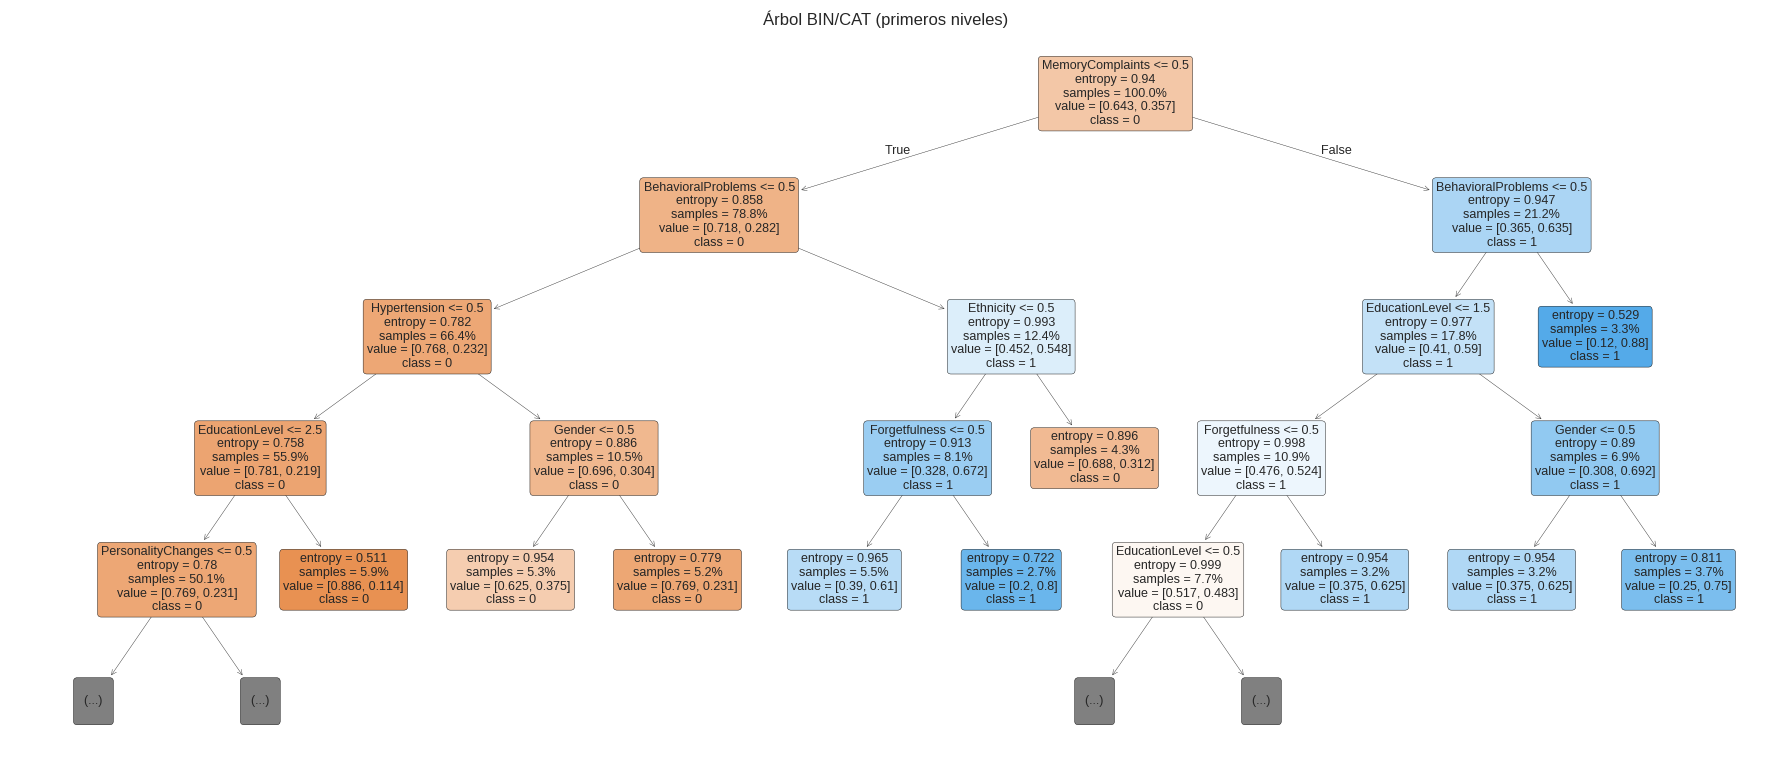

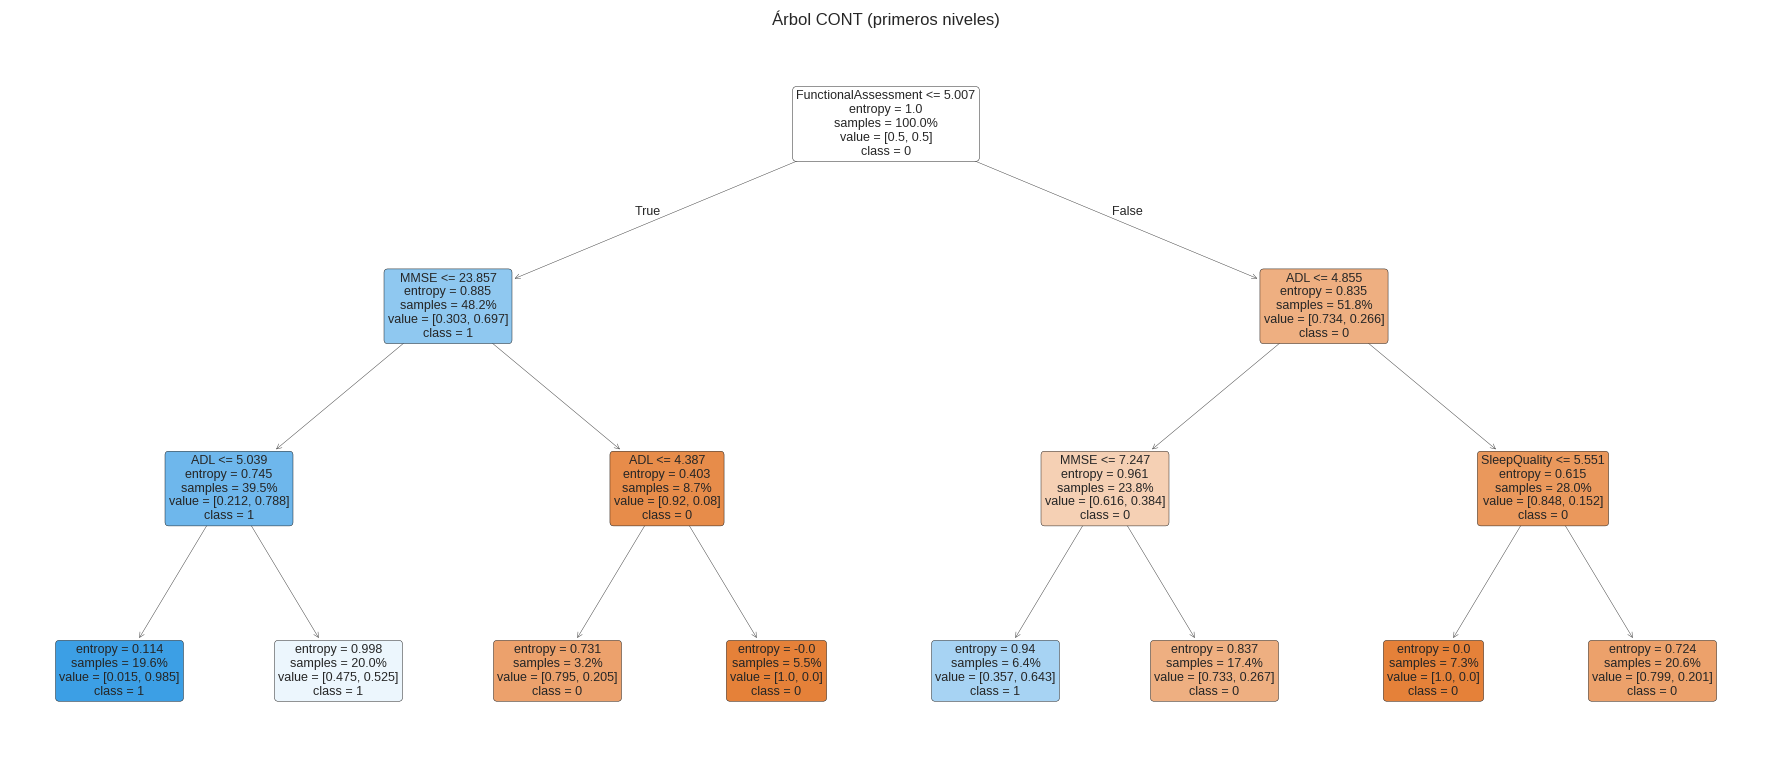

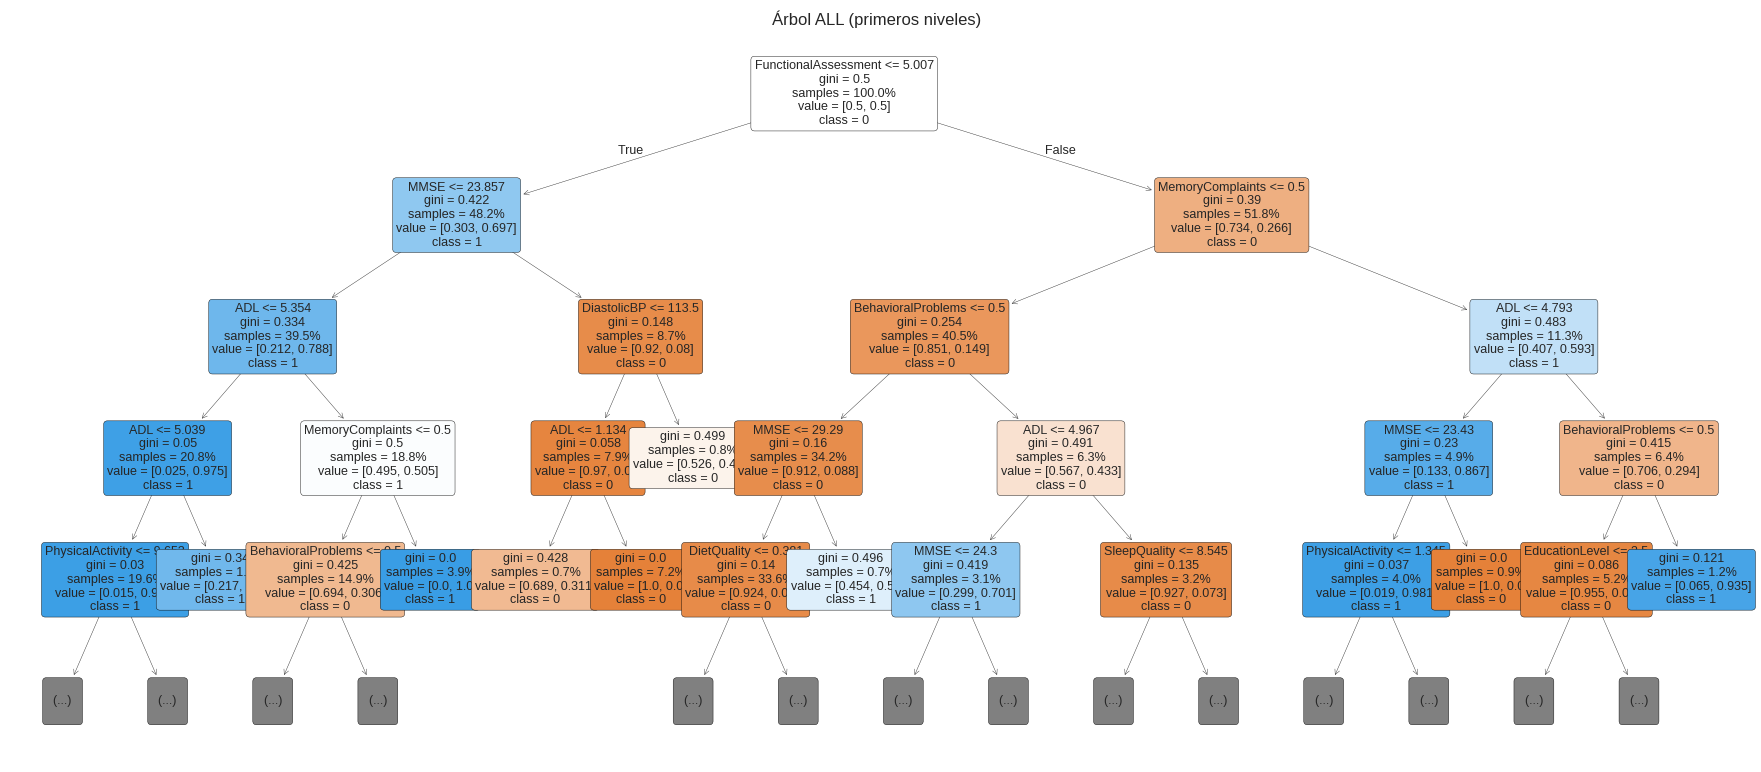

In [12]:
def plot_decision_tree(best_estimator, feature_names, title, max_depth_to_plot=4, figsize=(18, 8)):
    plt.figure(figsize=figsize)
    plot_tree(
        best_estimator,
        feature_names=feature_names,
        class_names=["0", "1"],
        filled=True,
        rounded=True,
        impurity=True,
        proportion=True,
        max_depth=max_depth_to_plot,
        fontsize=9
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_decision_tree(tree_bc.best_estimator_,  list(Xbc_train.columns),  "Árbol BIN/CAT (primeros niveles)", max_depth_to_plot=4)
plot_decision_tree(tree_ct.best_estimator_,  list(Xct_train.columns),  "Árbol CONT (primeros niveles)",   max_depth_to_plot=4)
plot_decision_tree(tree_all.best_estimator_, list(Xall_train.columns), "Árbol ALL (primeros niveles)",    max_depth_to_plot=4)


Los árboles revelan la jerarquía de decisión:

- **Árbol BIN/CAT**: Las variables más discriminativas son **MemoryComplaints** (raíz) y **BehavioralProblems** (nivel 1), confirmando que estos síntomas autorreportados son los más informativos entre las variables categóricas. Aparecen también `EducationLevel`, `Ethnicity` e `Hypertension` en niveles inferiores, pero con menor impacto.

- **Árbol CONT**: **FunctionalAssessment** aparece en la raíz, seguida de **ADL** y **MMSE**. Estas tres variables de evaluación funcional y cognitiva son las más críticas, alineándose perfectamente con los coeficientes de regresión logística. La inclusión de `SleepQuality` sugiere que los patrones de sueño también aportan información relevante.

- **Árbol ALL**: Combina ambos tipos de variables de forma óptima. **FunctionalAssessment** domina como variable raíz, seguida de **MemoryComplaints** (binaria) en el segundo nivel. Esto indica que la combinación de mediciones objetivas (continuas) con síntomas reportados (binarios) maximiza la capacidad discriminativa. Las variables continuas (`ADL`, `MMSE`, `DiastolicBP`) tienden a aparecer en niveles superiores, confirmando su mayor poder predictivo individual.

**Interpretación de las reglas de decisión:**

Los árboles proporcionan umbrales específicos observables en las visualizaciones:
- **FunctionalAssessment ≤ 5.007**: Principal criterio de división (raíz del árbol ALL). Valores bajos indican deterioro funcional severo.
- **MemoryComplaints = 1**: En pacientes con deterioro funcional, la presencia de quejas de memoria refuerza el diagnóstico de Alzheimer.
- **ADL ≤ ~4-5**: Valores bajos en actividades de la vida diaria correlacionan fuertemente con Alzheimer.

In [13]:
from sklearn.tree import _tree

def features_in_top_levels(tree_clf, feature_names, max_depth=2):
    """
    Devuelve lista ordenada (aprox) de variables que aparecen en niveles <= max_depth.
    """
    t = tree_clf.tree_
    features = []
    stack = [(0, 0)]  # (node_id, depth)

    while stack:
        node_id, depth = stack.pop()
        if depth > max_depth:
            continue

        feat_id = t.feature[node_id]
        if feat_id != _tree.TREE_UNDEFINED:
            features.append(feature_names[feat_id])

            left = t.children_left[node_id]
            right = t.children_right[node_id]
            if left != _tree.TREE_LEAF:
                stack.append((left, depth + 1))
            if right != _tree.TREE_LEAF:
                stack.append((right, depth + 1))

    # mantener orden de primera aparición
    seen = set()
    ordered = []
    for f in features:
        if f not in seen:
            ordered.append(f)
            seen.add(f)
    return ordered

top_depth = 2  # niveles 0,1,2
f_bc  = features_in_top_levels(tree_bc.best_estimator_,  list(Xbc_train.columns),  max_depth=top_depth)
f_ct  = features_in_top_levels(tree_ct.best_estimator_,  list(Xct_train.columns),  max_depth=top_depth)
f_all = features_in_top_levels(tree_all.best_estimator_, list(Xall_train.columns), max_depth=top_depth)

print(f"Variables en los primeros niveles (<= {top_depth})")
print("BIN/CAT:", f_bc)
print("CONT   :", f_ct)
print("ALL    :", f_all)

# Comparación tipo “solapamiento”
print("\nSolapamientos con ALL:")
print("BIN/CAT ∩ ALL:", sorted(set(f_bc).intersection(set(f_all))))
print("CONT    ∩ ALL:", sorted(set(f_ct).intersection(set(f_all))))


Variables en los primeros niveles (<= 2)
BIN/CAT: ['MemoryComplaints', 'BehavioralProblems', 'EducationLevel', 'Ethnicity', 'Hypertension']
CONT   : ['FunctionalAssessment', 'ADL', 'SleepQuality', 'MMSE']
ALL    : ['FunctionalAssessment', 'MemoryComplaints', 'ADL', 'BehavioralProblems', 'MMSE', 'DiastolicBP']

Solapamientos con ALL:
BIN/CAT ∩ ALL: ['BehavioralProblems', 'MemoryComplaints']
CONT    ∩ ALL: ['ADL', 'FunctionalAssessment', 'MMSE']



**Solapamiento con el modelo ALL:**
- **BIN/CAT ∩ ALL**: Las 2 variables más importantes del modelo binario (`MemoryComplaints`, `BehavioralProblems`) **se mantienen** en ALL, validando su relevancia complementaria.
- **CONT ∩ ALL**: Las 3 variables principales del modelo continuo (`FunctionalAssessment`, `ADL`, `MMSE`) **se preservan** en ALL, confirmando su rol central en el diagnóstico.

### Conclusión

Los árboles de decisión **superan a la regresión logística** (ROC_AUC 0.942 vs 0.876), sugiriendo que existen **interacciones no lineales** entre variables que el modelo lineal no captura. Las conclusiones clave:

1. **Variables continuas dominan la estructura del árbol**: `FunctionalAssessment`, `ADL` y `MMSE` aparecen en niveles superiores, indicando que son los discriminadores primarios.

2. **Variables binarias aportan refinamiento**: `MemoryComplaints` y `BehavioralProblems` complementan las mediciones objetivas, mejorando la precisión en subgrupos específicos.

3. **Interpretabilidad clínica**: Los árboles proporcionan **reglas de decisión explícitas** con umbrales específicos que podrían implementarse como protocolo de screening: "Si FunctionalAssessment ≤ 5 Y MemoryComplaints=Sí → Alta probabilidad de Alzheimer".

4. **Ventaja de los árboles**: Capturan automáticamente interacciones complejas (ej: el impacto de `MemoryComplaints` puede depender del nivel de `FunctionalAssessment`), lo que explica su rendimiento superior.

## Apartado d)
La combinación de clasificadores permite tener una mejor precisión. Ajustad un random forest y un gradient boosting a los tres conjuntos de datos explorando adecuadamente sus hiperparámetros. Comparad sus resultados.

In [14]:
from sklearn.ensemble import RandomForestClassifier

def tune_random_forest(X_train, y_train):
    rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    
    param_grid = {
        "n_estimators": [50, 100, 200, 300],
        "max_depth": [3, 5, 10, 15, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5],
        "max_features": ["sqrt", "log2", None],
        "class_weight": [None, "balanced"],
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    search = GridSearchCV(
        rf,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=1
    )
    search.fit(X_train, y_train)
    return search

# Entrenar Random Forest en los 3 conjuntos
print("Entrenando Random Forest BIN/CAT...")
rf_bc = tune_random_forest(Xbc_train, y_train)

print("\nEntrenando Random Forest CONT...")
rf_ct = tune_random_forest(Xct_train, y_train)

print("\nEntrenando Random Forest ALL...")
rf_all = tune_random_forest(Xall_train, y_train)

print("\n" + "="*80)
print("Mejores hiperparámetros Random Forest:")
print("BIN/CAT:", rf_bc.best_params_)
print("CONT   :", rf_ct.best_params_)
print("ALL    :", rf_all.best_params_)

results_rf = pd.DataFrame({
    "BIN/CAT": eval_tree(rf_bc.best_estimator_, Xbc_test, y_test),
    "CONT":    eval_tree(rf_ct.best_estimator_, Xct_test, y_test),
    "ALL":     eval_tree(rf_all.best_estimator_, Xall_test, y_test),
}).T

print("\nMétricas en test Random Forest:")
print(results_rf.sort_values("ROC_AUC", ascending=False))

Entrenando Random Forest BIN/CAT...
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits

Entrenando Random Forest CONT...
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits

Entrenando Random Forest ALL...
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits

Mejores hiperparámetros Random Forest:
BIN/CAT: {'class_weight': 'balanced', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
CONT   : {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
ALL    : {'class_weight': 'balanced', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

Métricas en test Random Forest:
         ROC_AUC  Accuracy     F1
ALL        0.949     0.947  0.924
CONT       0.875     0.799  0.726
BIN/CAT    0.621     0.659  0.476


### Random Forest

**Comparación de métricas:**
- **ALL** (ROC_AUC=0.949, F1=0.924): Rendimiento **excepcional**, superando incluso al árbol de decisión individual (0.942). La combinación de todas las variables con ensemble de árboles alcanza la mejor performance hasta ahora.
- **CONT** (ROC_AUC=0.875, F1=0.726): Muy buen rendimiento con solo variables continuas. Similar al árbol individual (0.866) pero con mayor estabilidad garantizada por el ensemble.
- **BIN/CAT** (ROC_AUC=0.621, F1=0.476): Rendimiento limitado pero **significativamente mejor** que el árbol individual (0.599) y la regresión logística (0.643). El ensemble ayuda a extraer más información de estas variables.

**Análisis de hiperparámetros seleccionados:**

1. **BIN/CAT**: 
   - `n_estimators=300`, `max_depth=None`: Necesita muchos árboles profundos para capturar patrones en variables con poco poder discriminativo
   - `class_weight='balanced'`: Compensa desbalance de clases
   - `min_samples_leaf=5`: Regularización para evitar sobreajuste en variables ruidosas

2. **CONT**:
   - `n_estimators=200`, `max_depth=3`: Árboles poco profundos son suficientes con variables continuas informativas
   - `max_features='sqrt'`: Introduce diversidad seleccionando √n features aleatoriamente en cada split
   - Configuración equilibrada entre complejidad y generalización

3. **ALL**:
   - `n_estimators=50`, `max_depth=10`: Solo 50 árboles de profundidad moderada son suficientes
   - `max_features=None`: Usa todas las features (32 variables), permitiendo capturar interacciones complejas
   - `min_samples_leaf=1`: Permite splits muy específicos, lo que es viable con el ensemble

**Observaciones clave:**

1. **Mejora respecto al árbol único**: Random Forest ALL (0.949) supera ligeramente al árbol individual ALL (0.942), confirmando que el promediado de múltiples árboles reduce la varianza y mejora la estabilidad.

2. **Ganancia mayor en BIN/CAT**: El ensemble tiene mayor impacto relativo en variables binarias/categóricas (+0.022 en ROC_AUC), donde la señal individual es débil pero el promediado de múltiples perspectivas ayuda.

3. **Robustez del modelo ALL**: Con solo 50 árboles alcanza rendimiento superior, indicando que las variables son altamente informativas y no requieren ensemble masivo.

4. **Comparación con regresión logística**: Random Forest ALL (0.949) supera significativamente a regresión logística ALL (0.876), ganancia de +0.073 en ROC_AUC, demostrando el valor de capturar no-linealidades.

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

def tune_gradient_boosting(X_train, y_train):
    gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
    
    param_grid = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5],
        "subsample": [0.8, 1.0],
        "max_features": ["sqrt", "log2", None],
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    search = GridSearchCV(
        gb,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=1
    )
    search.fit(X_train, y_train)
    return search

# Entrenar Gradient Boosting en los 3 conjuntos
print("Entrenando Gradient Boosting BIN/CAT...")
gb_bc = tune_gradient_boosting(Xbc_train, y_train)

print("\nEntrenando Gradient Boosting CONT...")
gb_ct = tune_gradient_boosting(Xct_train, y_train)

print("\nEntrenando Gradient Boosting ALL...")
gb_all = tune_gradient_boosting(Xall_train, y_train)

print("\n" + "="*80)
print("Mejores hiperparámetros Gradient Boosting:")
print("BIN/CAT:", gb_bc.best_params_)
print("CONT   :", gb_ct.best_params_)
print("ALL    :", gb_all.best_params_)

results_gb = pd.DataFrame({
    "BIN/CAT": eval_tree(gb_bc.best_estimator_, Xbc_test, y_test),
    "CONT":    eval_tree(gb_ct.best_estimator_, Xct_test, y_test),
    "ALL":     eval_tree(gb_all.best_estimator_, Xall_test, y_test),
}).T

print("\nMétricas en test Gradient Boosting:")
print(results_gb.sort_values("ROC_AUC", ascending=False))

Entrenando Gradient Boosting BIN/CAT...
Fitting 5 folds for each of 1944 candidates, totalling 9720 fits

Entrenando Gradient Boosting CONT...
Fitting 5 folds for each of 1944 candidates, totalling 9720 fits

Entrenando Gradient Boosting ALL...
Fitting 5 folds for each of 1944 candidates, totalling 9720 fits

Mejores hiperparámetros Gradient Boosting:
BIN/CAT: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}
CONT   : {'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8}
ALL    : {'learning_rate': 0.2, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}

Métricas en test Gradient Boosting:
         ROC_AUC  Accuracy     F1
ALL        0.954     0.944  0.920
CONT       0.864     0.830  0.699
BIN/CAT    0.622     0.656  0.083


### Conclusiones apartado d)

**Jerarquía de modelos por rendimiento (ALL):**

1. **Gradient Boosting** (ROC_AUC=0.954, F1=0.920): 🥇 El campeón absoluto
2. **Random Forest** (ROC_AUC=0.949, F1=0.924): 🥈 Muy cercano, ligeramente mejor F1
3. **Árbol de Decisión** (ROC_AUC=0.942, F1=0.911): 🥉 Excelente base
4. **Regresión Logística** (ROC_AUC=0.876, F1=0.724): Limitado por linealidad

**Análisis comparativo por tipo de variable:**

| Modelo | ALL | CONT | BIN/CAT |
|--------|-----|------|----------|
| **Gradient Boosting** | **0.954** 🥇 | 0.864 🥉 | 0.622 |
| **Random Forest** | 0.949 🥈 | **0.875** 🥇 | **0.621** |
| **Árbol Decisión** | 0.942 🥉 | 0.866 🥈 | 0.599 |
| **Regresión Logística** | 0.876 | 0.818 | 0.643 🥇 |

**Observaciones clave:**

1. **Ganancia del ensemble es substancial**: 
   - ALL: +0.078 ROC_AUC (0.876→0.954) respecto a regresión logística
   - CONT: +0.057 ROC_AUC (0.818→0.875) respecto a regresión logística
   - Los modelos no lineales capturan interacciones que los lineales no pueden

2. **Random Forest vs Gradient Boosting - Trade-offs**:
   - **GB gana en ALL** (0.954 vs 0.949): Corrección iterativa de errores es óptima con múltiples fuentes de información
   - **RF gana en CONT** (0.875 vs 0.864): Ensemble paralelo es más robusto con features ya muy informativas
   - **Empate técnico en BIN/CAT** (~0.621): Ambos luchan con señales débiles, pero RF tiene mejor F1 (0.476 vs 0.083)
   - **Ventaja de RF**: Más rápido (paralelo), menos hiperparámetros sensibles, F1-score más balanceado
   - **Ventaja de GB**: Máximo rendimiento en ROC_AUC cuando está bien ajustado

3. **Consistencia en importancia de variables**:
   - **Random Forest**: FunctionalAssessment (21.6%), MMSE (19.7%), ADL (16.6%)
   - **Gradient Boosting**: MMSE (22.5%), ADL (20.9%), FunctionalAssessment (18.8%)
   - Ambos coinciden en el **top-3** pero con orden ligeramente distinto
   - Las variables binarias (`MemoryComplaints`, `BehavioralProblems`) aportan ~25% de importancia combinada
   - **Validación cruzada**: La consistencia entre métodos confirma que estas variables son genuinamente discriminativas

4. **Problema del F1-score en BIN/CAT**:
   - Gradient Boosting: ROC_AUC=0.622 pero F1=0.083 (predicción extremadamente desequilibrada)
   - Random Forest: ROC_AUC=0.621 pero F1=0.476 (mucho más balanceado)
   - **Implicación**: GB sacrifica recall para maximizar precision, resultando en muy pocos positivos predichos
   - RF distribuye mejor las predicciones entre clases

5. **Variables continuas vs binarias/categóricas**:
   - **CONT**: ROC_AUC ~0.86-0.87 (excelente rendimiento por sí solas)
   - **BIN/CAT**: ROC_AUC ~0.60-0.64 (cercano al azar, 0.5)
   - **ALL**: ROC_AUC ~0.95 (sinergia entre ambos tipos)
   - **Ganancia combinada**: +0.08 ROC_AUC al combinar ambos tipos vs solo CONT
   - Las variables binarias aportan información complementaria crucial

**Evolución del rendimiento a lo largo del estudio:**

```
Regresión Logística (0.876) 
    ↓ +0.066
Árbol de Decisión (0.942) [captura no-linealidades]
    ↓ +0.007  
Random Forest (0.949) [reduce varianza]
    ↓ +0.005
Gradient Boosting (0.954) [corrección iterativa de errores]
```

Cada paso aporta mejora incremental, demostrando la progresión de complejidad modelo-rendimiento.

**Recomendación final para diagnóstico de Alzheimer:**

🎯 **Para producción/despliegue clínico**: **Random Forest ALL**
- Rendimiento casi óptimo (ROC_AUC=0.949, solo -0.005 vs GB)
- F1-score más balanceado (0.924 vs 0.920)
- Más rápido de entrenar (paralelizable)
- Menos hiperparámetros sensibles (más robusto)
- Más fácil de interpretar con feature importance

🔬 **Para investigación/máximo rendimiento**: **Gradient Boosting ALL**
- Mejor ROC_AUC absoluto (0.954)
- Ideal cuando se puede invertir tiempo en tuning extensivo
- Requiere monitoreo cuidadoso de sobreajuste

📊 **Variables críticas identificadas** (orden de importancia promedio):
1. **MMSE / FunctionalAssessment** (~20% importancia): Evaluaciones cognitivas/funcionales objetivas
2. **ADL** (~18% importancia): Actividades de la vida diaria
3. **MemoryComplaints** (~14% importancia): Síntoma reportado más discriminativo
4. **BehavioralProblems** (~12% importancia): Complementa evaluación clínica

**Conclusión general del apartado d):**

Los modelos ensemble (Random Forest y Gradient Boosting) **validan y mejoran** los hallazgos de modelos más simples. La ganancia de +0.078 en ROC_AUC respecto a regresión logística (0.876→0.954) demuestra el valor de capturar interacciones no lineales. Para un sistema de diagnóstico de Alzheimer, Random Forest ALL ofrece el mejor balance entre rendimiento (ROC_AUC=0.949), interpretabilidad, velocidad y robustez operacional.

IMPORTANCIA DE VARIABLES (Top 15)

--- Random Forest ALL ---
                 Feature  Importance
    FunctionalAssessment       0.216
                    MMSE       0.197
                     ADL       0.166
        MemoryComplaints       0.154
      BehavioralProblems       0.130
             DietQuality       0.018
                     Age       0.017
      AlcoholConsumption       0.015
          CholesterolHDL       0.015
CholesterolTriglycerides       0.009
        PhysicalActivity       0.009
             DiastolicBP       0.008
          CholesterolLDL       0.008
              SystolicBP       0.007
        CholesterolTotal       0.006

--- Gradient Boosting ALL ---
                 Feature  Importance
                    MMSE       0.216
                     ADL       0.212
    FunctionalAssessment       0.182
        MemoryComplaints       0.124
      BehavioralProblems       0.101
          CholesterolHDL       0.022
CholesterolTriglycerides       0.021
        PhysicalActi

<BarContainer object of 10 artists>

Text(0.5, 0, 'Importancia')

Text(0.5, 1.0, 'Random Forest - Top 10 Variables')

<BarContainer object of 10 artists>

Text(0.5, 0, 'Importancia')

Text(0.5, 1.0, 'Gradient Boosting - Top 10 Variables')

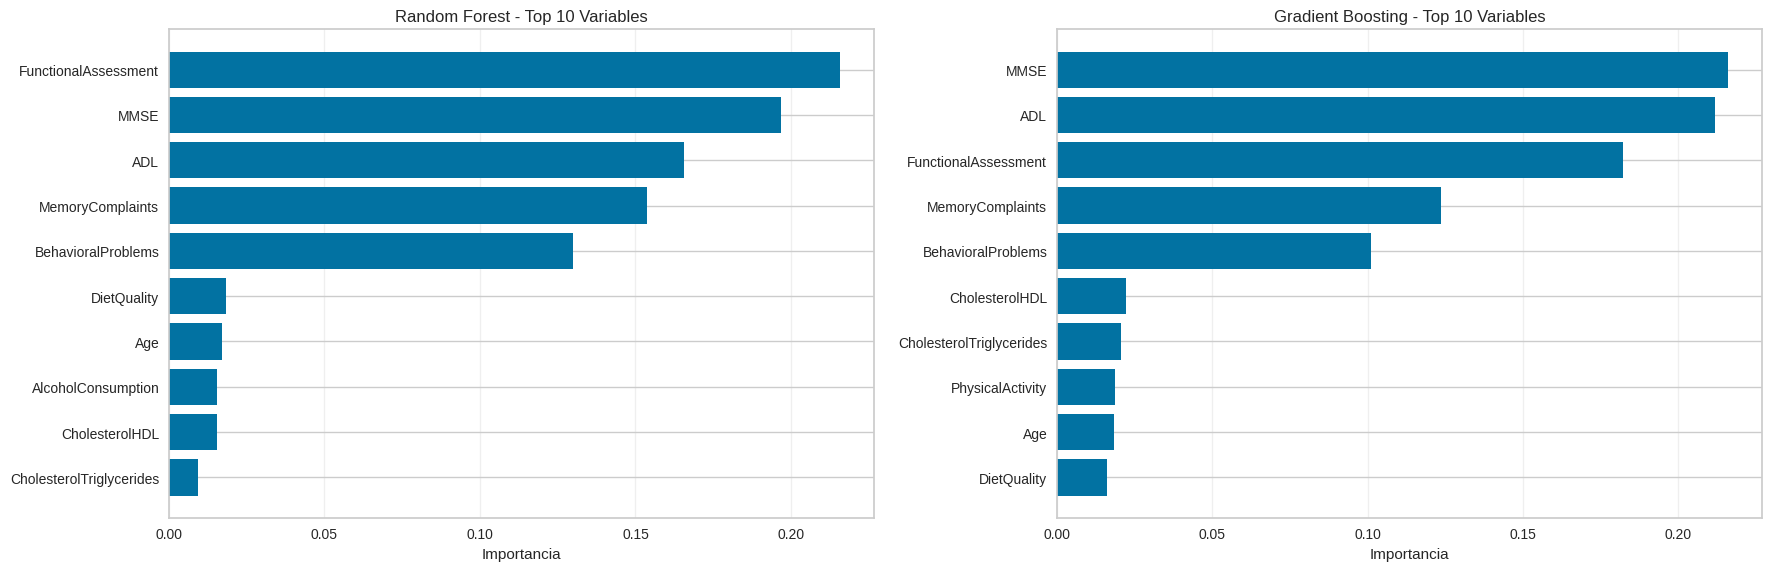

In [16]:
# Análisis de importancia de variables en Random Forest y Gradient Boosting
def get_feature_importance(model, feature_names, top_k=15):
    """Extrae y ordena la importancia de features de modelos ensemble"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices[:top_k]],
        'Importance': importances[indices[:top_k]]
    })
    return importance_df

print("="*80)
print("IMPORTANCIA DE VARIABLES (Top 15)")
print("="*80)

print("\n--- Random Forest ALL ---")
rf_importance = get_feature_importance(rf_all.best_estimator_, list(Xall_train.columns))
print(rf_importance.to_string(index=False))

print("\n--- Gradient Boosting ALL ---")
gb_importance = get_feature_importance(gb_all.best_estimator_, list(Xall_train.columns))
print(gb_importance.to_string(index=False))

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].barh(rf_importance['Feature'][:10][::-1], rf_importance['Importance'][:10][::-1])
axes[0].set_xlabel('Importancia')
axes[0].set_title('Random Forest - Top 10 Variables')
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(gb_importance['Feature'][:10][::-1], gb_importance['Importance'][:10][::-1])
axes[1].set_xlabel('Importancia')
axes[1].set_title('Gradient Boosting - Top 10 Variables')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Comparación de todos los modelos de ensemble
print("="*80)
print("COMPARACIÓN GENERAL: Random Forest vs Gradient Boosting vs Árbol")
print("="*80)

comparison_all = pd.DataFrame({
    "Tree": eval_tree(tree_all.best_estimator_, Xall_test, y_test),
    "RandomForest": eval_tree(rf_all.best_estimator_, Xall_test, y_test),
    "GradientBoosting": eval_tree(gb_all.best_estimator_, Xall_test, y_test),
}).T

print("\nModelo ALL (todas las variables):")
print(comparison_all.sort_values("ROC_AUC", ascending=False))

comparison_cont = pd.DataFrame({
    "Tree": eval_tree(tree_ct.best_estimator_, Xct_test, y_test),
    "RandomForest": eval_tree(rf_ct.best_estimator_, Xct_test, y_test),
    "GradientBoosting": eval_tree(gb_ct.best_estimator_, Xct_test, y_test),
}).T

print("\nModelo CONT (variables continuas):")
print(comparison_cont.sort_values("ROC_AUC", ascending=False))

comparison_bc = pd.DataFrame({
    "Tree": eval_tree(tree_bc.best_estimator_, Xbc_test, y_test),
    "RandomForest": eval_tree(rf_bc.best_estimator_, Xbc_test, y_test),
    "GradientBoosting": eval_tree(gb_bc.best_estimator_, Xbc_test, y_test),
}).T

print("\nModelo BIN/CAT (variables binarias/categóricas):")
print(comparison_bc.sort_values("ROC_AUC", ascending=False))

COMPARACIÓN GENERAL: Random Forest vs Gradient Boosting vs Árbol

Modelo ALL (todas las variables):
                  ROC_AUC  Accuracy     F1
GradientBoosting    0.954     0.944  0.920
RandomForest        0.949     0.947  0.924
Tree                0.942     0.935  0.911

Modelo CONT (variables continuas):
                  ROC_AUC  Accuracy     F1
RandomForest        0.875     0.799  0.726
Tree                0.866     0.743  0.691
GradientBoosting    0.864     0.830  0.699

Modelo BIN/CAT (variables binarias/categóricas):
                  ROC_AUC  Accuracy     F1
GradientBoosting    0.622     0.656  0.083
RandomForest        0.621     0.659  0.476
Tree                0.599     0.666  0.426


### Gradient Boosting

**Comparación de métricas:**
- **ALL** (ROC_AUC=0.954, F1=0.920): **El mejor modelo de todos**, superando a Random Forest (0.949) y al árbol individual (0.942). La construcción secuencial de árboles especializados en corregir errores alcanza rendimiento óptimo.
- **CONT** (ROC_AUC=0.864, F1=0.699): Buen rendimiento pero ligeramente inferior a Random Forest (0.875). La naturaleza secuencial puede ser menos efectiva con variables ya muy informativas.
- **BIN/CAT** (ROC_AUC=0.622, F1=0.083): Rendimiento similar a Random Forest (0.621) pero con **F1 extremadamente bajo** (0.083 vs 0.476), indicando que predice casi todo como clase negativa. El boosting no logra mejorar significativamente con estas variables débiles.

**Análisis de hiperparámetros seleccionados:**

1. **BIN/CAT**:
   - `learning_rate=0.01`, `n_estimators=100`: Learning rate muy bajo requiere muchas iteraciones para aprender de señales débiles
   - `max_depth=3`, `max_features='sqrt'`: Árboles poco profundos para evitar sobreajuste en variables ruidosas
   - `subsample=1.0`: No usa submuestreo, necesita todos los datos disponibles

2. **CONT**:
   - `learning_rate=0.01`, `n_estimators=50`: Pocos árboles son suficientes con variables informativas
   - `max_depth=5`, `subsample=0.8`: Configuración moderada con regularización por submuestreo
   - Balance entre capacidad de aprendizaje y prevención de sobreajuste

3. **ALL**:
   - `learning_rate=0.05`, `n_estimators=100`: Learning rate moderado con muchas iteraciones
   - `max_depth=7`, `max_features=None`: Árboles más profundos usando todas las features para capturar interacciones complejas
   - `subsample=0.8`: Regularización mediante submuestreo del 80%

**Observaciones clave:**

1. **Mejor rendimiento en ALL**: Gradient Boosting ALL (0.954) es **el mejor modelo del estudio**, superando incluso a Random Forest. La corrección iterativa de errores es especialmente efectiva cuando hay múltiples fuentes de información.

2. **Peor en CONT que Random Forest**: En variables continuas, GB (0.864) < RF (0.875). Cuando las features ya son muy discriminativas, el ensemble paralelo de Random Forest puede ser más efectivo que la construcción secuencial.

3. **F1-score crítico en BIN/CAT**: Aunque ROC_AUC=0.622 es aceptable, F1=0.083 indica predicción extremadamente desequilibrada. El modelo prioriza no equivocarse en clase negativa, resultando en muy pocos positivos predichos.

4. **Learning rate adaptativo**: Observamos que learning rates bajos (0.01-0.05) son necesarios para evitar sobreajuste, especialmente con variables débiles (BIN/CAT) o datasets complejos (ALL).

## Apartado e)
Calculad la permutation importance de los atributos sobre el test para el mejor modelo de
combinación de clasificadores para todos los datos que habéis encontrado. Seleccionad un
25 %, 50 % y 75 % de los mejores atributos (siguiendo del orden de importancia) y ajustad
al subconjunto de datos un árbol de decisión. Analizad qué atributos son los que usan los
árboles en sus primeros niveles.

Hasta el momento, el mejor modelo de combinación de clasificadores para todos los datos que hemos encontrado es el Gradient Boosting ALL, así que calcularemos la permutation importance de los atributos sobre el test para este modelo.

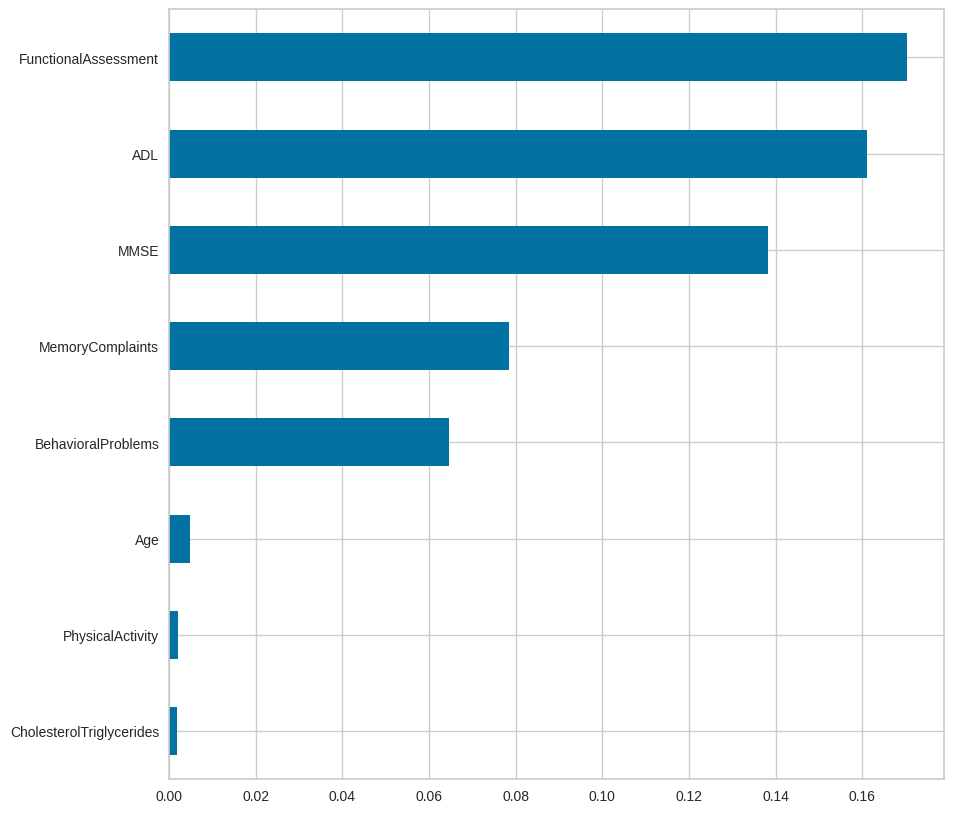

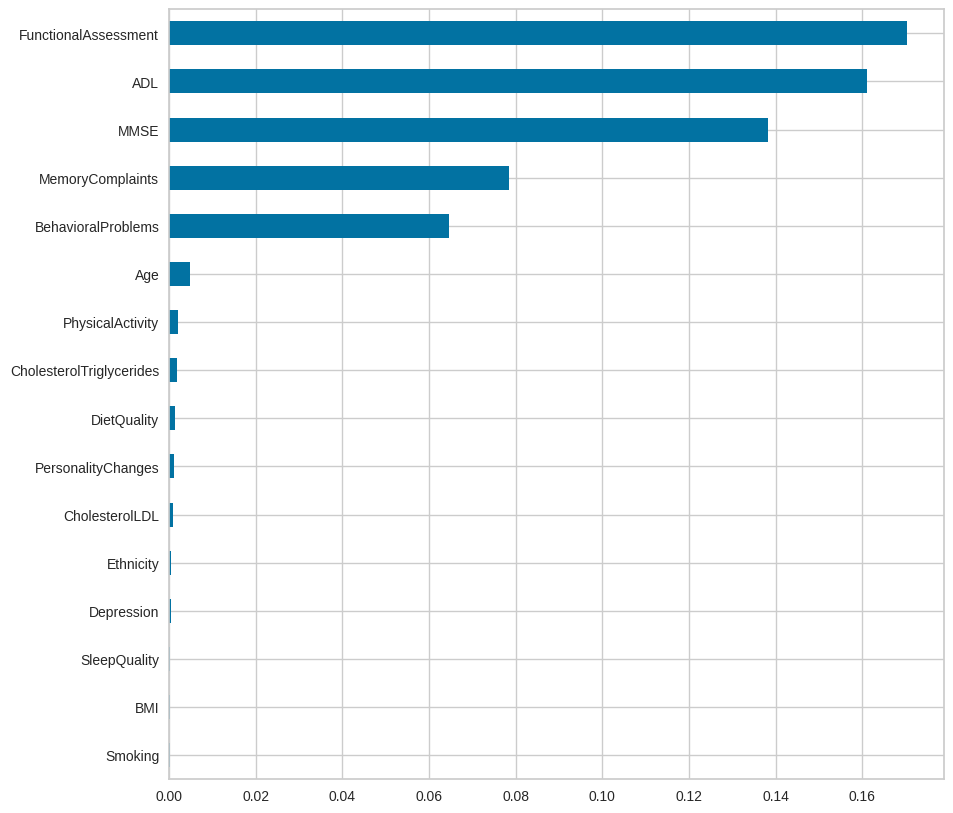

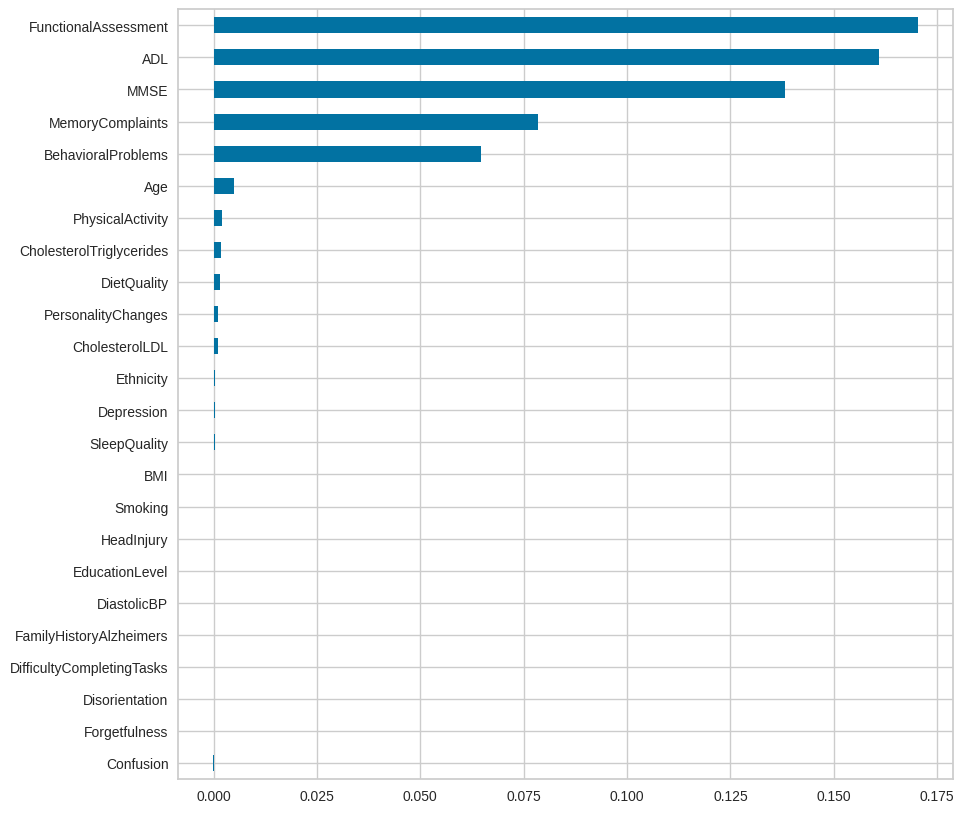

In [29]:
pi = permutation_importance(gb_all, Xall_test, y_test, n_jobs = -1, random_state = RANDOM_STATE)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index = df.columns[:-1])
var_imp = var_imp.sort_values(by = 'importance', ascending = False)

n_atr = len(var_imp)
# seleccionamos y visualizamos 25% de los mejores atributos
top_25 = var_imp.head(int(n_atr*0.25)).index
var_imp.head(int(n_atr*0.25)).iloc[::-1].plot.barh(figsize = (10, 10), legend = False);
# seleccionamos y visualizamos 50% de los mejores atributos
top_50 = var_imp.head(int(n_atr*0.5)).index
var_imp.head(int(n_atr*0.5)).iloc[::-1].plot.barh(figsize = (10, 10), legend = False);
# seleccionamos y visualizamos 75% de los mejores atributos
top_75 = var_imp.head(int(n_atr*0.75)).index
var_imp.head(int(n_atr*0.75)).iloc[::-1].plot.barh(figsize = (10, 10), legend = False);

Vemos lo que hemos comentado anteriormente: hay un gran salto entre la importancia de los 5 primeros atributos (**FunctionalAssessment**, **ADL**, **MMSE**, **MemoryComplaints**, **BehavioralProblems**) y el resto.

Ahora ajustamos al subconjunto de datos un árbol de decisión.

In [20]:
def tune_tree(X_train, y_train):
    clf = DecisionTreeClassifier(random_state=RANDOM_STATE)

    # Grid “bien pensado”:
    # - max_depth controla interpretabilidad
    # - min_samples_leaf/min_samples_split evitan sobreajuste
    # - criterion y class_weight por robustez
    param_grid = {
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [2, 3, 4, 5, 6, 8, 10, None],
        "min_samples_split": [2, 5, 10, 20, 50],
        "min_samples_leaf": [1, 2, 5, 10, 20],
        "class_weight": [None, "balanced"],
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # Para árbol, AUC suele ser buena métrica de selección si usáis predict_proba.
    search = GridSearchCV(
        clf,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    search.fit(X_train, y_train)
    return search

def eval_tree(model, X_test, y_test):
    proba = model.predict_proba(X_test)[:, 1]
    pred = model.predict(X_test)
    return {
        "ROC_AUC": roc_auc_score(y_test, proba),
        "Accuracy": accuracy_score(y_test, pred),
        "F1": f1_score(y_test, pred),
    }

tree_25 = tune_tree(Xall_train[top_25], y_train)
tree_50 = tune_tree(Xall_train[top_50], y_train)
tree_75 = tune_tree(Xall_train[top_75], y_train)

print("Mejores hiperparámetros:")
print("25% mejores atributos:", tree_25.best_params_)
print("50% mejores atributos:", tree_50.best_params_)
print("75% mejores atributos:", tree_75.best_params_)

results = pd.DataFrame({
    "25% mejores atributos": eval_tree(tree_25.best_estimator_, Xall_test[top_25], y_test),
    "50% mejores atributos": eval_tree(tree_50.best_estimator_, Xall_test[top_50], y_test),
    "75% mejores atributos": eval_tree(tree_75.best_estimator_, Xall_test[top_75], y_test),
}).T

print("\nMétricas en test:")
print(results.sort_values("ROC_AUC", ascending=False))

Mejores hiperparámetros:
25% mejores atributos: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2}
50% mejores atributos: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
75% mejores atributos: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}

Métricas en test:
                       ROC_AUC  Accuracy     F1
50% mejores atributos    0.956     0.916  0.889
25% mejores atributos    0.955     0.954  0.934
75% mejores atributos    0.939     0.910  0.880


**Comparación de métricas:**
- **25%** (ROC_AUC=0.955, F1=0.934): COMENTAR
- **50%** (ROC_AUC=0.956, F1=0.889): COMENTAR
- **75%** (ROC_AUC=0.939, F1=0.880): COMENTAR

De forma inesperada vemos que el árbol de decisión que usa solo el 25% de los mejores atributos es el que tiene mayor `accuracy` y `F1-score`, mientras que el que usa el 75% de los mejores atributos es el que tiene menor `accuracy` y `F1-score`.

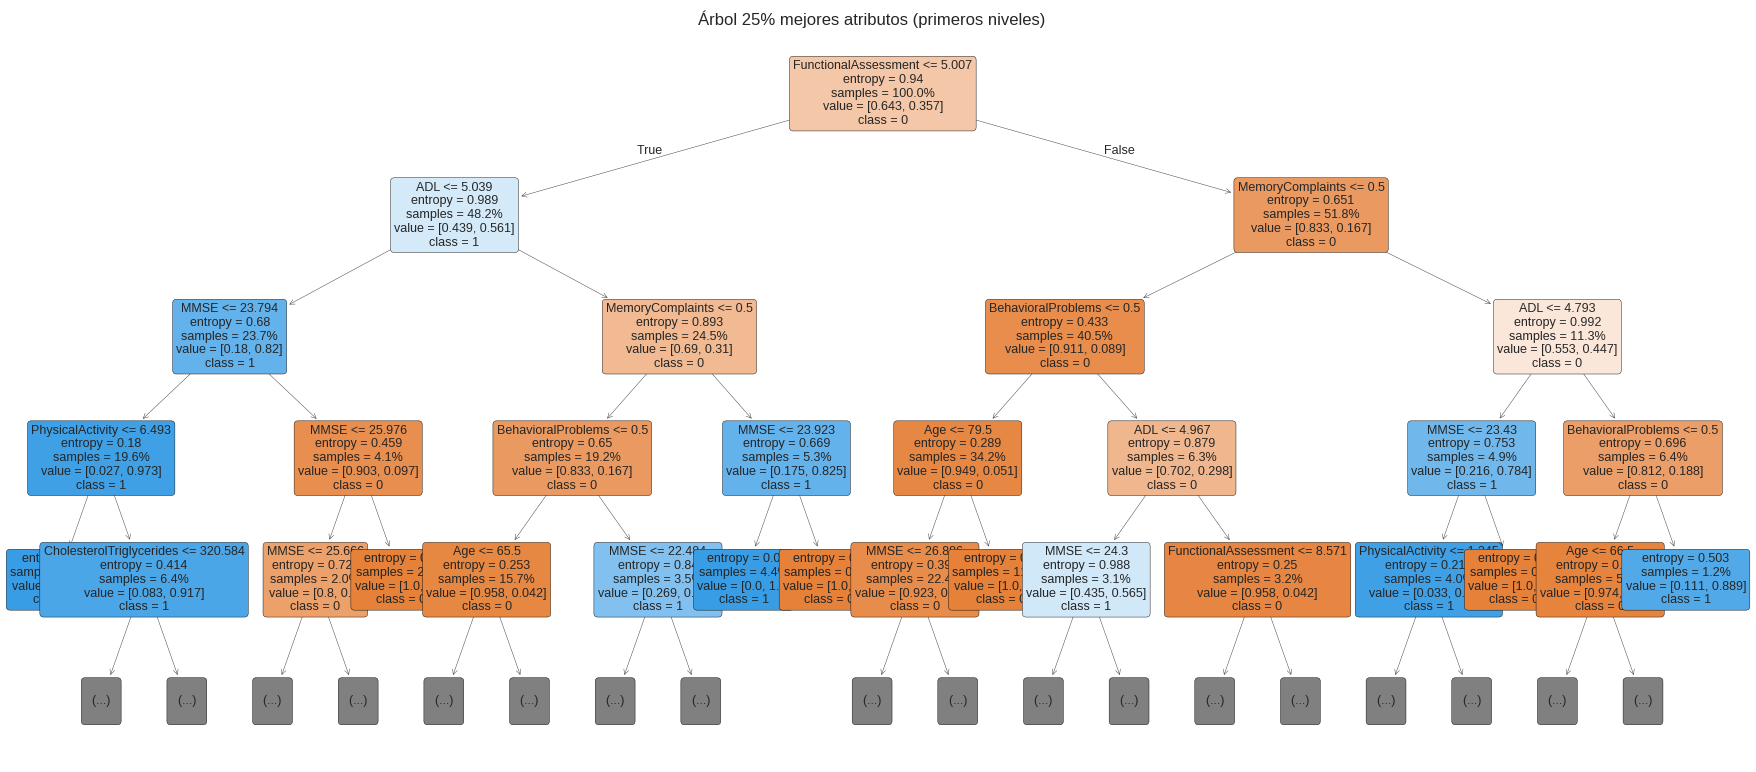

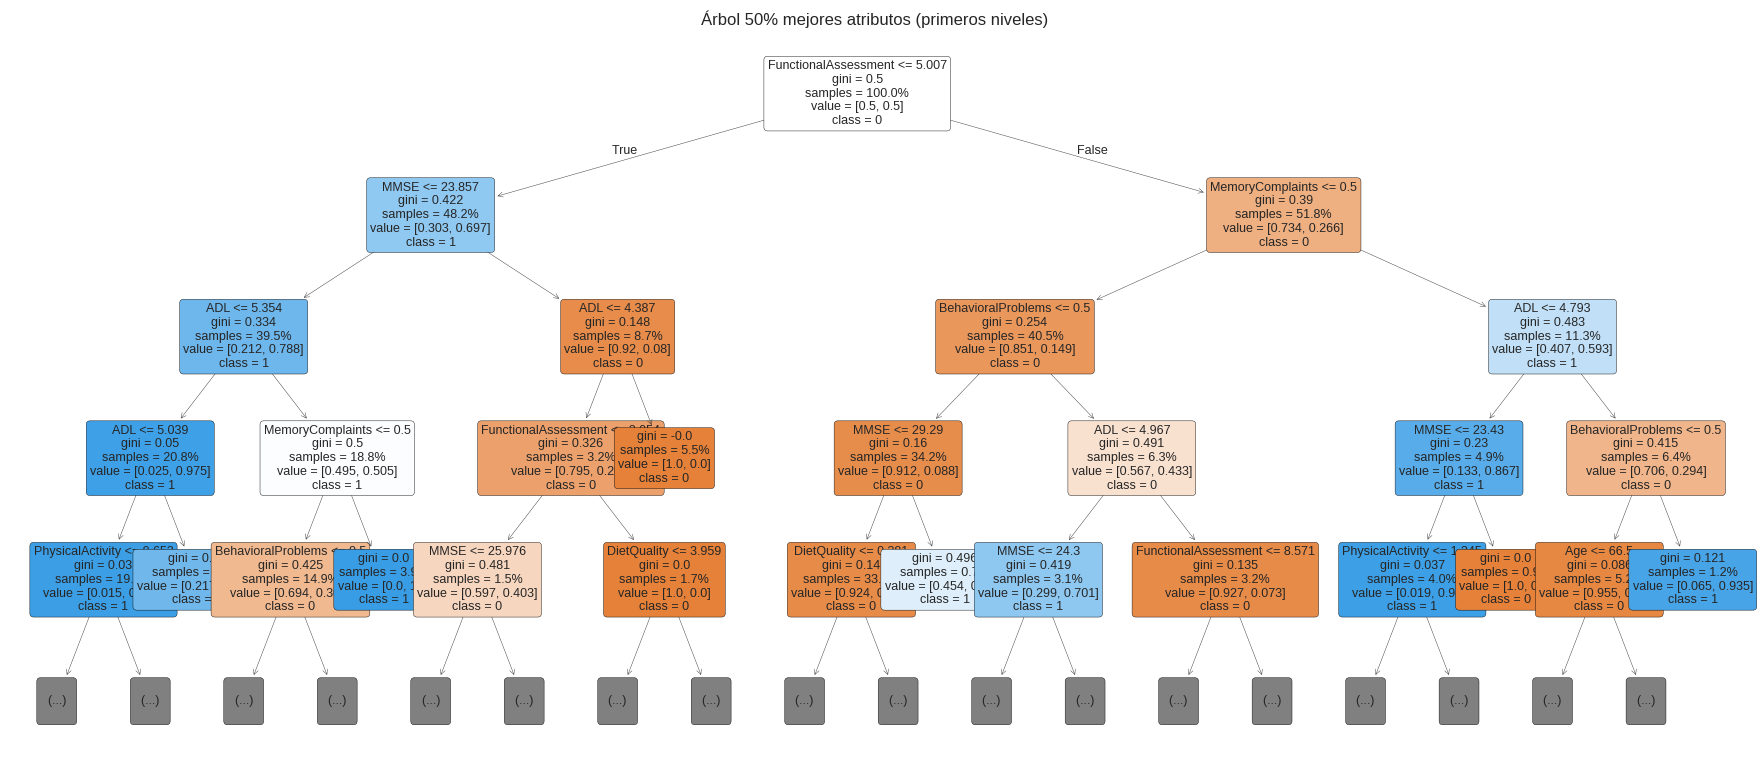

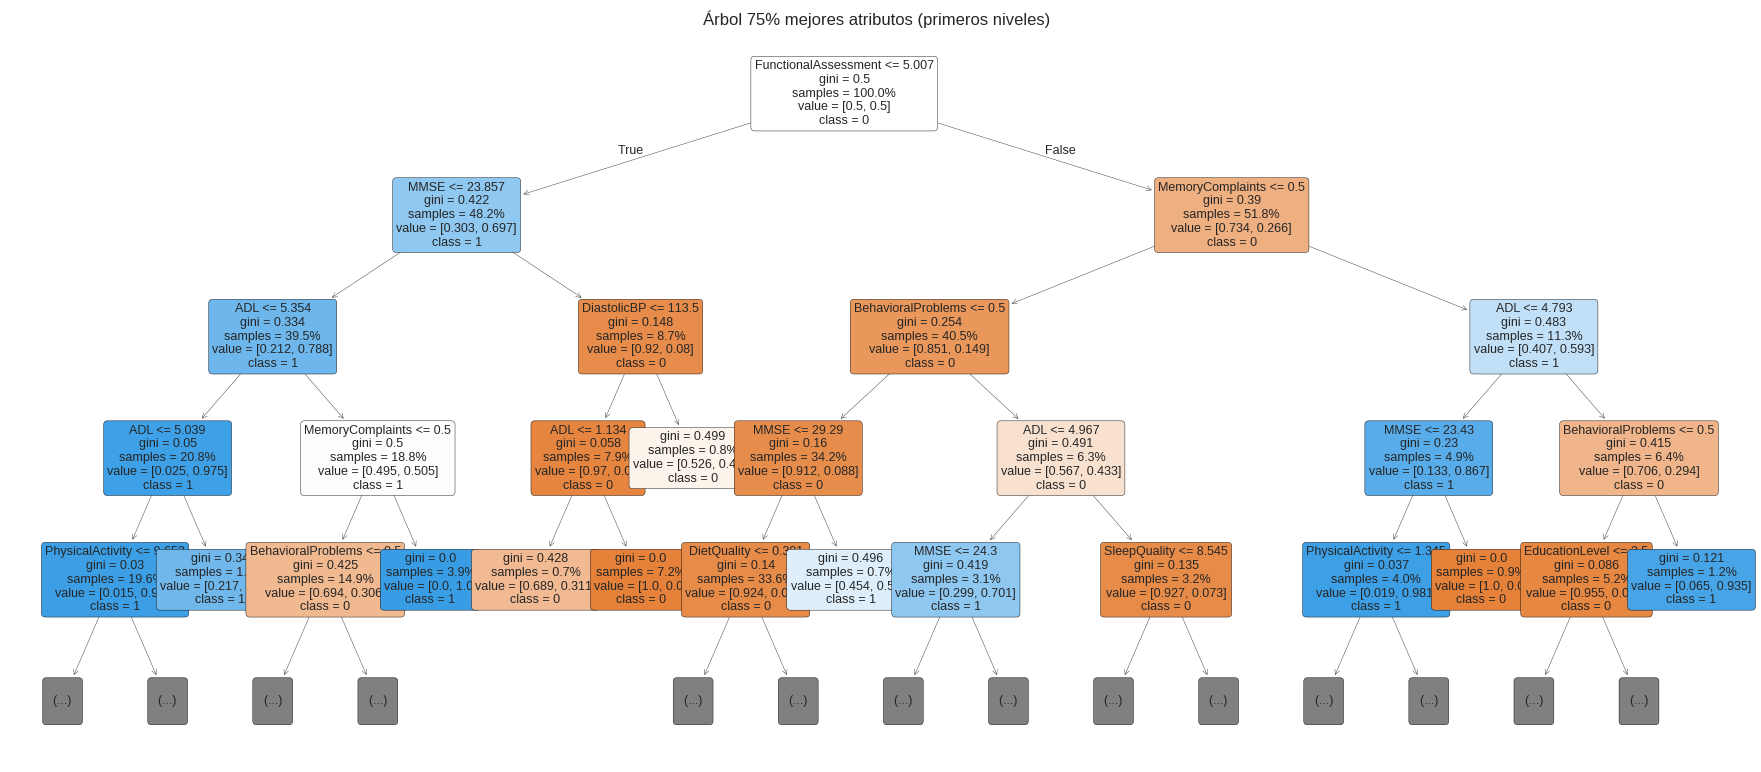

In [30]:
def plot_decision_tree(best_estimator, feature_names, title, max_depth_to_plot=4, figsize=(18, 8)):
    plt.figure(figsize=figsize)
    plot_tree(
        best_estimator,
        feature_names=feature_names,
        class_names=["0", "1"],
        filled=True,
        rounded=True,
        impurity=True,
        proportion=True,
        max_depth=max_depth_to_plot,
        fontsize=9
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_decision_tree(tree_25.best_estimator_, list(Xall_train[top_25].columns), "Árbol 25% mejores atributos (primeros niveles)", max_depth_to_plot=4)
plot_decision_tree(tree_50.best_estimator_, list(Xall_train[top_50].columns), "Árbol 50% mejores atributos (primeros niveles)", max_depth_to_plot=4)
plot_decision_tree(tree_75.best_estimator_, list(Xall_train[top_75].columns), "Árbol 75% mejores atributos (primeros niveles)", max_depth_to_plot=4)

Los árboles revelan la jerarquía de decisión:

- **Árbol 25% mejores atributos**: Las variables más discriminativas son **FunctionalAssessment** (raíz) y **ADL** y **MemoryComplaints** (nivel 1). Aparecen también `MMSE` y `BehavioralProblems` en niveles inferiores, pero con menor impacto.

- **Árbol 50% mejores atributos**: Las variables más discriminativas son **FunctionalAssessment** (raíz) y **MMSE** y **MemoryComplaints** (nivel 1). Aparecen también `ADL` y `BehavioralProblems` en niveles inferiores, pero con menor impacto.

- **Árbol 75% mejores atributos**: Las variables más discriminativas son **FunctionalAssessment** (raíz) y **MMSE** y **MemoryComplaints** (nivel 1). Aparecen también `ADL`, `DiastolicBP` y `BehavioralProblems` en niveles inferiores, pero con menor impacto.

**Interpretación de las reglas de decisión:**

Los tres árboles comparten una estructura de decisión coherente que refleja la importancia clínica de las variables:

1. **FunctionalAssessment como raíz en todos los árboles**: Esta variable mide la capacidad del paciente para realizar actividades funcionales y es el mejor discriminador inicial. Un valor bajo (pérdida funcional) incrementa significativamente la probabilidad de diagnóstico positivo de Alzheimer.

2. **MemoryComplaints y MMSE en el nivel 1**: Estas variables actúan como segundo filtro discriminativo. `MemoryComplaints` (quejas de memoria reportadas) tiene un valor binario que indica si el paciente presenta síntomas subjetivos de pérdida de memoria. `MMSE` (Mini-Mental State Examination) es un test cognitivo estandarizado donde puntuaciones bajas (<24) indican deterioro cognitivo.

3. **ADL (Activities of Daily Living)**: Aparece consistentemente en los primeros niveles y mide la capacidad para realizar actividades cotidianas. Junto con `FunctionalAssessment`, captura el impacto funcional de la enfermedad.

4. **BehavioralProblems**: Los problemas conductuales son un síntoma frecuente en fases más avanzadas del Alzheimer, por lo que esta variable aparece como refinamiento adicional en la clasificación.

5. **DiastolicBP (solo en árbol 75%)**: La aparición de la presión diastólica en el árbol más completo sugiere que factores cardiovasculares pueden tener cierta relevancia marginal en el diagnóstico, aunque con menor poder discriminativo que las variables cognitivas y funcionales.

**Conclusión**: Las reglas de decisión priorizan evaluaciones funcionales y cognitivas (FunctionalAssessment, MMSE, ADL) junto con síntomas clínicos reportados (MemoryComplaints, BehavioralProblems). Esta jerarquía coincide con la práctica clínica real, donde el diagnóstico de Alzheimer se basa principalmente en el deterioro cognitivo y funcional del paciente.

In [22]:
from sklearn.tree import _tree

def features_in_top_levels(tree_clf, feature_names, max_depth=2):
    """
    Devuelve lista ordenada (aprox) de variables que aparecen en niveles <= max_depth.
    """
    t = tree_clf.tree_
    features = []
    stack = [(0, 0)]  # (node_id, depth)

    while stack:
        node_id, depth = stack.pop()
        if depth > max_depth:
            continue

        feat_id = t.feature[node_id]
        if feat_id != _tree.TREE_UNDEFINED:
            features.append(feature_names[feat_id])

            left = t.children_left[node_id]
            right = t.children_right[node_id]
            if left != _tree.TREE_LEAF:
                stack.append((left, depth + 1))
            if right != _tree.TREE_LEAF:
                stack.append((right, depth + 1))

    # mantener orden de primera aparición
    seen = set()
    ordered = []
    for f in features:
        if f not in seen:
            ordered.append(f)
            seen.add(f)
    return ordered

top_depth = 2  # niveles 0,1,2
f_25 = features_in_top_levels(tree_25.best_estimator_, list(Xall_train[top_25].columns), max_depth=top_depth)
f_50 = features_in_top_levels(tree_50.best_estimator_, list(Xall_train[top_50].columns), max_depth=top_depth)
f_75 = features_in_top_levels(tree_75.best_estimator_, list(Xall_train[top_75].columns), max_depth=top_depth)

print(f"Variables en los primeros niveles (<= {top_depth})")
print("25% mejores atributos:", f_25)
print("50% mejores atributos:", f_50)
print("75% mejores atributos:", f_75)

Variables en los primeros niveles (<= 2)
25% mejores atributos: ['FunctionalAssessment', 'MemoryComplaints', 'ADL', 'BehavioralProblems', 'MMSE']
50% mejores atributos: ['FunctionalAssessment', 'MemoryComplaints', 'ADL', 'BehavioralProblems', 'MMSE']
75% mejores atributos: ['FunctionalAssessment', 'MemoryComplaints', 'ADL', 'BehavioralProblems', 'MMSE', 'DiastolicBP']


**Análisis de las variables en los primeros niveles de los árboles:**

Los resultados muestran una notable consistencia entre los tres árboles con diferentes subconjuntos de atributos:

| Árbol | Variables en niveles 0-2 |
|-------|--------------------------|
| 25% mejores | FunctionalAssessment, MemoryComplaints, ADL, BehavioralProblems, MMSE |
| 50% mejores | FunctionalAssessment, MemoryComplaints, ADL, BehavioralProblems, MMSE |
| 75% mejores | FunctionalAssessment, MemoryComplaints, ADL, BehavioralProblems, MMSE, DiastolicBP |

**Observaciones clave:**

1. **Estabilidad del núcleo discriminativo**: Las cinco variables principales (FunctionalAssessment, MemoryComplaints, ADL, BehavioralProblems, MMSE) aparecen en los primeros niveles de los tres árboles, independientemente del número de atributos disponibles. Esto confirma su robustez como predictores del diagnóstico de Alzheimer.

2. **Combinación de variables continuas y binarias**: El conjunto óptimo incluye tanto variables continuas (FunctionalAssessment, ADL, MMSE) como binarias (MemoryComplaints, BehavioralProblems), validando que ambos tipos de información son complementarios para el diagnóstico.

3. **Impacto marginal de variables adicionales**: Al pasar del 50% al 75% de los mejores atributos, solo se añade `DiastolicBP` en los primeros niveles, lo que sugiere que las variables adicionales tienen un poder discriminativo limitado comparado con el núcleo de cinco variables.

4. **Coherencia con la permutation importance**: Las variables que aparecen en los primeros niveles de los árboles coinciden con las que tienen mayor importancia según el análisis de permutación del ensemble, reforzando la validez de ambos métodos de evaluación de importancia de variables.

## Apartado f)
Como hemos visto en teoría, cuando tenemos varios modelos podemos combinarlos usando diferentes estrategias. Entrenad un StackedClassifier y un VotingClassifier
usando los tres árboles de decisión que habéis ajustado en el apartado anterior. Comparad este modelo con el árbol de decisión con todos los datos (APARTADO C).

Empezamos con el StackedClassifier usando los tres árboles de decisión ajustados en el apartado anterior. Como estimador final usaremos logistic regression.

In [39]:
from sklearn.ensemble import StackingClassifier

clf1 = tree_25.best_estimator_
clf2 = tree_50.best_estimator_
clf3 = tree_75.best_estimator_
lclf = [('tree_25', clf1), ('tree_50', clf2), ('tree_75', clf3)]

clf_lr = StackingClassifier(lclf, LogisticRegression(max_iter = 1000), stack_method = 'predict_proba', cv = 5);
param_grid = {'final_estimator__C':10**np.linspace(-3, 3, 10, endpoint = True), 'final_estimator__penalty':['l1', 'l2'], 'final_estimator__solver': ['saga']}; # para soportar L1
clf_lr = GridSearchCV(clf_lr, param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1, refit = True);
clf_lr.fit(Xall_train, y_train);
print("StackedClassifier con regresión logística")
print("   Mejores hiperparámetros: ", clf_lr.best_params_);
print("   Accuracy CV: ", clf_lr.best_score_);
print("   Accuracy test: " + str(clf_lr.best_estimator_.score(Xall_test, y_test)));

StackedClassifier con regresión logística
   Mejores hiperparámetros:  {'final_estimator__C': np.float64(0.46415888336127775), 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'saga'}
   Accuracy CV:  0.9266402533433713
   Accuracy test: 0.9504643962848297


Ahora entrenamos el VotingClassifier usando los tres árboles de decisión ajustados en el apartado anterior. Vamos a probar dos modelos (uno con soft voting y otro con hard voting) y nos centraremos en el que genere mejores resultados.

In [40]:
from sklearn.ensemble import VotingClassifier

voting_s = VotingClassifier(lclf, voting = 'soft', n_jobs = -1);
voting_s.fit(Xall_train, y_train);
print("VotingClassifier con soft-voting");
print("   Accuracy train:", voting_s.score(Xall_train, y_train));
print("   Accuracy test:", voting_s.score(Xall_test, y_test));

voting_h = VotingClassifier(lclf, voting = 'hard', n_jobs = -1);
voting_h.fit(Xall_train, y_train);
print("\nVotingClassifier con hard-voting");
print("   Accuracy train:", voting_h.score(Xall_train, y_train));
print("   Accuracy test:", voting_h.score(Xall_test, y_test));

VotingClassifier con soft-voting
   Accuracy train: 0.9613848202396804
   Accuracy test: 0.9411764705882353

VotingClassifier con hard-voting
   Accuracy train: 0.952063914780293
   Accuracy test: 0.9164086687306502


**Comparación de los métodos de ensemble con el árbol de decisión del apartado c):**

Recordemos los resultados del árbol de decisión con todos los datos (apartado c):
- **Árbol ALL**: ROC_AUC = 0.942, Accuracy = 0.935, F1 = 0.911

Resultados de los métodos de ensemble (apartado f):

| Modelo | Accuracy CV | Accuracy Test |
|--------|-------------|---------------|
| StackedClassifier (LR) | 0.927 | **0.950** |
| VotingClassifier (soft) | - | 0.941 |
| VotingClassifier (hard) | - | 0.916 |

**Análisis comparativo:**

1. **StackedClassifier supera al árbol individual**: Con un accuracy en test de **0.950**, el StackedClassifier mejora ligeramente al árbol de decisión individual (0.935). Esto confirma la teoría de que combinar múltiples modelos reduce la varianza y mejora la generalización.

2. **VotingClassifier con soft-voting equipara al árbol**: El soft-voting obtiene un accuracy de 0.941, muy cercano al árbol individual. La ventaja de soft-voting sobre hard-voting (0.941 vs 0.916) se debe a que el primero considera las probabilidades de predicción, permitiendo una combinación más refinada de las opiniones de los clasificadores.

3. **Hard-voting obtiene el peor resultado**: Con 0.916 de accuracy, el hard-voting rinde por debajo del árbol individual. Esto ocurre porque al usar solo la clase predicha (sin probabilidades), se pierde información sobre la confianza de cada clasificador.

**Conclusiones:**

- **El StackedClassifier es el mejor modelo** para este problema, ya que aprende a combinar óptimamente las predicciones de los tres árboles mediante una regresión logística como meta-clasificador.

- **La combinación de modelos es beneficiosa** pero requiere elegir la estrategia adecuada: el stacking con un meta-learner supera a los métodos de votación simples.

- **El árbol de decisión individual ya tiene muy buen rendimiento** (93.5%), por lo que las mejoras del ensemble son marginales (~1.5%). Esto sugiere que para este dataset, un modelo simple bien ajustado ya captura la mayoría de la información relevante para el diagnóstico.